In [1]:
from oop import *
from func import *
from deap import base, creator, tools, algorithms



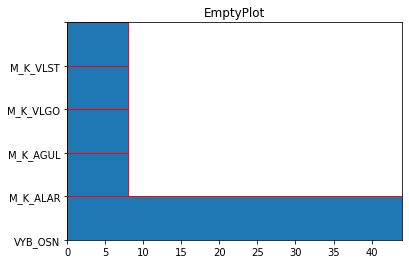

0

In [2]:
timetables = timetables_from_excel('data/TimeTable.xlsx')
mechanics, electrics = create_workers_from_array(timetables)
tm = Timetable(3, mechanics)

tasks = tasks_from_excel('data/БДСМ.xlsx')
filtered_tasks = tasks_from_df(tasks, '2020-04-09T00:00:00')
fm = Field(tm, filtered_tasks)
fm.randomize_timelines()
fm.plot_empty()


In [3]:
creator.create("Fitness", base.Fitness, weights=(-1.0,))
creator.create("Individual", Field, fitness=creator.Fitness)


In [4]:
toolbox = base.Toolbox()
toolbox.register("individual", creator.Individual,tm, filtered_tasks)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [5]:
def eval_tt(individual):
    return individual.loss(),


In [6]:
def crossover(ind1, ind2):
    """Apply a crossover operation on input sets. The first child is the
    intersection of the two sets, the second child is the difference of the
    two sets.
    """
    ch1_tasks = []
    ch2_tasks = []
    default_tt = ind1.timetable
    mask = np.random.randint(2, size=len(ind1.tasks)).tolist()
    for t1, t2, m in zip(ind1.tasks, ind2.tasks, mask):
        if m == 0:
            ch1_tasks.append(t1)
            ch2_tasks.append(t2)
        else:
            ch1_tasks.append(t2)
            ch2_tasks.append(t1)

    ch1 = creator.Individual(default_tt, ch1_tasks, randomized=False)
    ch2 = creator.Individual(default_tt, ch2_tasks, randomized=False)

    return ch1, ch2


In [7]:
def mutation(individual):
    """Mutation that pops or add an element."""
    if random.random()<0.9:
        print("SUPER")
        # individual.zero_gravity()
        individual.gravity()

    for task in individual.tasks:
        if random.random() < 0.5:
            if random.random() < 0.5:
                task.rnd_step(individual, individual.len_x, individual.len_y)
            else:
                task.rnd_relocate(individual, individual.len_x, individual.len_y)



    return individual,


In [8]:
toolbox.register("evaluate", eval_tt)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutation)
toolbox.register("select", tools.selTournament, tournsize=3)

In [9]:
pop = toolbox.population(n=100)

hof = tools.HallOfFame(1, similar=np.array_equal)

stats = tools.Statistics(lambda individ: individ.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


In [10]:
poppy, statss = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.5, ngen=150, stats=stats,
                    halloffame=hof
)


gen	nevals	avg   	std        	min   	max   
0  	100   	109.26	2.84217e-14	109.26	109.26
SUPER
step: 5, err: 1
step: 5, err: 2
step: 5, err: 1
step: 5, err: 1
step: 5, err: 2
step: 5, err: 1
step: 5, err: 2
step: 5, err: 3
step: 5, err: 4
step: 5, err: 5
step: 5, err: 1
step: 5, err: 2
step: 5, err: 3
step: 5, err: 4
step: 5, err: 5
step: 5, err: 6
step: 5, err: 1
step: 5, err: 2
step: 5, err: 3
step: 5, err: 4
step: 5, err: 5
step: 5, err: 6
step: 5, err: 1
step: 5, err: 2
step: 5, err: 3
step: 5, err: 4
step: 5, err: 5
step: 5, err: 6
step: 5, err: 7
step: 3, err: 1
step: 3, err: 2
step: 3, err: 3
step: 3, err: 4
step: 3, err: 5
step: 3, err: 6
step: 3, err: 1
step: 3, err: 2
step: 3, err: 3
step: 3, err: 4
step: 3, err: 5
step: 3, err: 6
step: 3, err: 7
step: 1, err: 1
step: 1, err: 2
step: 1, err: 3
step: 1, err: 4
step: 1, err: 5
step: 1, err: 6
step: 1, err: 1
step: 1, err: 2
step: 1, err: 3
step: 1, err: 4
step: 1, err: 5
step: 1, err: 6
step: 1, err: 7
step: 0.5, err: 1
step: 0.

KeyboardInterrupt: 

In [ ]:
best = hof[0]
best.plot()
best.statistics()


In [ ]:
gen, avg, min_, max_ = statss.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()


In [ ]:
best.zero_gravity()
best.plot()
best.gravity()
best.plot()
best.statistics()


In [ ]:
best.table_representation()
